In [1]:
import sys
sys.path.append("../../")

from transportnet import net
from transportnet import line
from transportnet import vehicle
from stochastic import stochastic

from genetics import ga

import folium
from leafmap import foliumap as leafmap

from matplotlib import pyplot as plt
from scipy import stats as ss
import numpy as np

In [2]:
n = net.Net()

n.load_nodes_from_file('verkhnodniprovsk_nodes.txt')
# define the network configuration
n.load_from_file('verkhnodniprovsk_edges.txt')

# define demand intensity
for nd in n.nodes:
    nd.s_interval = stochastic.Stochastic(law=2, scale=30)
central = n.get_node(code=1)
central.s_interval = stochastic.Stochastic(law=2, scale=5)

# define a set of public transport lines
line1 = line.Line(n, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                    13, 12, 11, 15, 16, 17, 18, 19, 1], 
                    [1, 14])
line1.same_back_direction = False
line1.color = 'red'
line1.add_vehicles([vehicle.Vehicle(18)])

line2 = line.Line(n, [1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 18, 31, 32, 16, 10, 1],
                    [1, 1])
line2.same_back_direction = False
line2.color = 'green'
line2.add_vehicles([vehicle.Vehicle(50)])
line3 = line.Line(n, [1, 20, 33, 34, 35, 36, 37, 38,
                    37, 39, 36, 35, 18, 19, 1],
                    [1, 38])
line3.same_back_direction = False
line3.color = 'brown'
line3.add_vehicles([vehicle.Vehicle(18)])
line4 = line.Line(n, [1, 3, 4, 40, 41, 42, 43, 44,
                    43, 42, 41, 40, 4, 3, 1],
                    [1, 44])
line4.same_back_direction = True
line4.color = 'blue'
line4.add_vehicles([vehicle.Vehicle(38)])
line5 = line.Line(n, [1, 3, 4, 40, 41, 42, 45, 46, 47,
                    46, 45, 42, 41, 40, 4, 3, 1],
                    [1, 47])
line5.same_back_direction = True
line5.color = 'grey'
line5.add_vehicles([vehicle.Vehicle(38)])

n.lines.extend([line1, line2, line3, line4, line5])

## Simulate net

In [3]:
sim_time = 2.0 * 60
n.duration = sim_time
model_runs = 5

def fitness_function(shifts):
    res = []
    for _ in range(model_runs):
        n.reset()
        for idx in range(len(n.lines)):
            n.lines[idx].schedule_shift = shifts[idx]
        n.gen_demand(duration=n.duration)
        x = n.simulate(sim_time)
        res.append(x)
    return np.array(res)
    # return sum(res) / len(res)
    # return n.simulate(sim_time)

mean_ff = lambda xs: fitness_function(xs).mean()

res = fitness_function([75, 90, 30, 95, 0])
# nss = len([p for p in n.demand if p.service_started])
# nsf = len([p for p in n.demand if p.service_finished])
# print(res, len(n.demand), nss, nsf)
res.mean(), mean_ff([0, 0, 0, 0, 0])

(49.33018358466178, 41.675910155575544)

## Run GA

In [68]:
winners = []
for iter in range(30):
    print(iter + 1)
    g = ga.GA()
    # 7 bits per a time shift value: in range between 0 and 127
    g.chromosome_size = len(n.lines), 7
    g.population_size = 100
    g.generations = 20
    g.crossover_probability = 0.5
    g.mutation_probability = 0.2
    g.mutation_turns = 3
    g.fitness_function = lambda xs: fitness_function(xs).mean()
    winner = g.run()
    winners.append(winner[1])
    print()

1
winner #1 ([13, 41, 12, 20, 25], (41.857474833113685, <genetics.chromosome.Chromosome object at 0x3036b5a20>))
winner #2 ([13, 41, 12, 20, 25], (41.37267242660353, <genetics.chromosome.Chromosome object at 0x3036b5a20>))
winner #3 ([18, 26, 50, 11, 1], (41.04635697513217, <genetics.chromosome.Chromosome object at 0x30344fac0>))
winner #4 ([26, 33, 12, 28, 25], (40.64253214963962, <genetics.chromosome.Chromosome object at 0x30369f4c0>))
winner #5 ([16, 3, 32, 7, 47], (40.11118450177665, <genetics.chromosome.Chromosome object at 0x30369f010>))
winner #6 ([16, 3, 32, 7, 47], (40.32968261231211, <genetics.chromosome.Chromosome object at 0x30369f010>))
winner #7 ([16, 3, 32, 7, 47], (39.9629996579023, <genetics.chromosome.Chromosome object at 0x303519300>))
winner #8 ([16, 1, 14, 26, 1], (39.30610447739398, <genetics.chromosome.Chromosome object at 0x30329d0c0>))
winner #9 ([16, 1, 14, 26, 0], (38.708405672000616, <genetics.chromosome.Chromosome object at 0x167a54a90>))
winner #10 ([16, 2

In [69]:
np.array(winners).tofile('net30x20.txt', sep=',', format='%s')

## Analyze results

In [5]:
xs = np.fromfile('net_results/net30x20.txt', sep=',').reshape((30, 20))

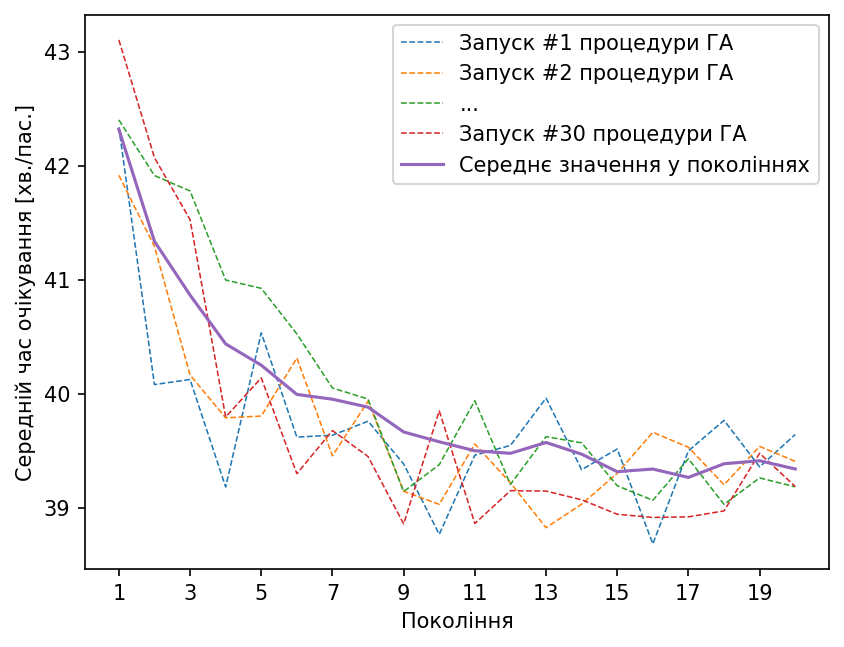

In [9]:
plt.figure(dpi=150)
plt.plot(range(1, 21), xs[9],lw=0.75, label=f'Запуск #1 процедури ГА', linestyle='--')
plt.plot(range(1, 21), xs[10], lw=0.75, label=f'Запуск #2 процедури ГА', linestyle='--')
plt.plot(range(1, 21), xs[11], lw=0.75, label=f'...', linestyle='--')
plt.plot(range(1, 21), xs[28], lw=0.75, label=f'Запуск #30 процедури ГА', linestyle='--')
plt.plot(range(1, 21), xs.mean(axis=0), lw=1.5, label=f'Середнє значення у поколіннях')
plt.ylabel('Середній час очікування [хв./пас.]')
plt.xlabel('Покоління')
plt.xticks(range(1, 21, 2))
plt.legend()
plt.show()  

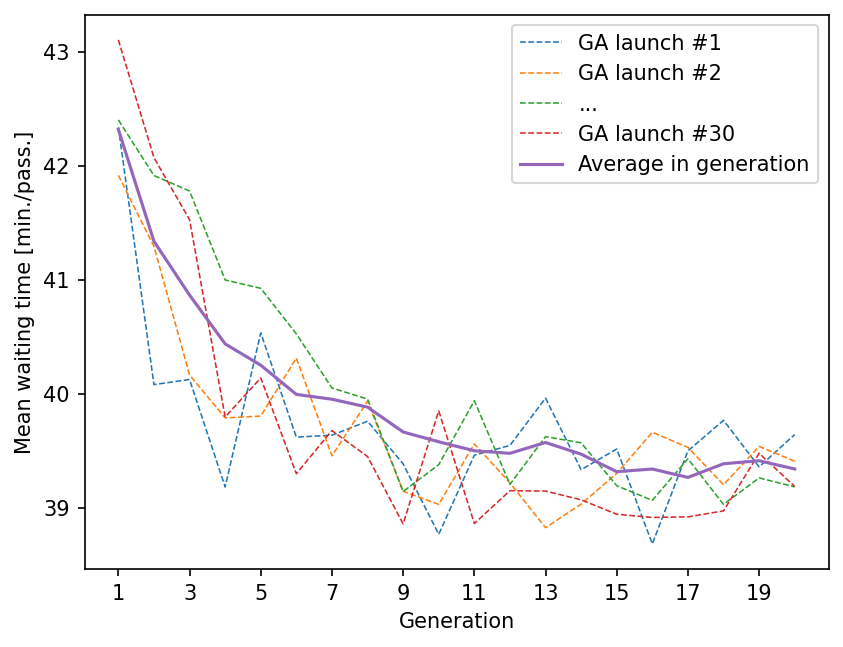

In [11]:
plt.figure(dpi=150)
plt.plot(range(1, 21), xs[9],lw=0.75, label=f'GA launch #1', linestyle='--')
plt.plot(range(1, 21), xs[10], lw=0.75, label=f'GA launch #2', linestyle='--')
plt.plot(range(1, 21), xs[11], lw=0.75, label=f'...', linestyle='--')
plt.plot(range(1, 21), xs[28], lw=0.75, label=f'GA launch #30', linestyle='--')
plt.plot(range(1, 21), xs.mean(axis=0), lw=1.5, label=f'Average in generation')
plt.ylabel('Mean waiting time [min./pass.]')
plt.xlabel('Generation')
plt.xticks(range(1, 21, 2))
plt.legend()
plt.show()  